In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Import necessary libraries for model selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (
    StackingRegressor,
    BaggingRegressor,
    AdaBoostRegressor,
    VotingRegressor,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings


#### Seleção do modelo para prever a colunas Approx. Total Revenue(INR)
def treat_outliers(df, col):
    z_scores = zscore(df[col])
    df_no_outliers = df[(z_scores < 3)]
    return df_no_outliers


def training_total_revenue(df):
    # Tratamento de outliers
    df = treat_outliers(df, "Approx. Total Revenue(INR)")

    # Preparando os dados para modelagem
    X = df.drop(
        columns=[
            "Approx. Total Revenue(INR)",
            "Price per Unit (sold)",
            "Quantity Sold (liters/kg)",
            "Total Value",
        ]
    )
    y = df["Approx. Total Revenue(INR)"]

    # Dividindo em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Definindo colunas categóricas e numéricas
    categorical_cols = [
        "Location",
        "Farm Size",
        "Product Name",
        "Brand",
        "Customer Location",
        "Sales Channel",
    ]
    numerical_cols = [
        "Total Land Area (acres)",
        "Number of Cows",
        "Quantity (liters/kg)",
        "Price per Unit",
        # "Total Value",
        "Shelf Life (days)",
        "Quantity in Stock (liters/kg)",
        "Minimum Stock Threshold (liters/kg)",
        "Reorder Quantity (liters/kg)",
        "Days Before Expire",
        "Days to Sell",
    ]

    # Pré-processamento
    cat_preprocessor = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))])
    num_preprocessor = Pipeline([("scaler", StandardScaler())])

    preprocessor = ColumnTransformer(
        [
            ("cat", cat_preprocessor, categorical_cols),
            ("num", num_preprocessor, numerical_cols),
        ]
    )

    # Pré-processando os dados
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    # Normalizando o target
    scaler = StandardScaler()
    y_train_normalized = scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_normalized = scaler.transform(y_test.values.reshape(-1, 1))

    # Definindo e ajustando o modelo Decision Tree
    decision_tree = DecisionTreeRegressor(random_state=42)

    # Otimização de hiperparâmetros
    decision_tree_params = {
        "max_depth": [None, 5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    }

    print("Tuning hyperparameters for Decision Tree...")
    grid_search = GridSearchCV(
        decision_tree,
        decision_tree_params,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
    )
    grid_search.fit(X_train_preprocessed, y_train_normalized.ravel())

    best_decision_tree = grid_search.best_estimator_
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Mean MSE: {-1 * grid_search.best_score_:.4f}\n")

    # Avaliação final com cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        best_decision_tree,
        X_train_preprocessed,
        y_train_normalized.ravel(),
        cv=cv,
        scoring="neg_mean_squared_error",
    )
    mean_mse = np.mean((-1) * scores)
    print(f"Decision Tree - Final Mean MSE: {mean_mse:.4f}")

    # Análise de importância de features
    categorical_transformer = preprocessor.named_transformers_["cat"]
    categorical_feature_names = categorical_transformer.named_steps[
        "onehot"
    ].get_feature_names_out(input_features=categorical_cols)
    feature_names = list(categorical_feature_names) + numerical_cols

    if hasattr(best_decision_tree, "feature_importances_"):
        feature_importances = best_decision_tree.feature_importances_
        sorted_indices = np.argsort(feature_importances)[::-1]

        print("\nFeature Importances for Decision Tree:")
        for i in sorted_indices:
            print(f"{feature_names[i]}: {feature_importances[i]:.4f}")
    else:
        print("The Decision Tree model does not have feature importances.")

    # Retornando os objetos necessários
    total_rev = {
        "model": best_decision_tree,
        "preprocessor": preprocessor,
        "scaler": scaler,
        "feature_names": feature_names,
    }
    return total_rev

def training_total_quantity_sold(df):
    print("Training model to predict Quantity Sold (liters/kg)...")
    # Tratamento de outliers
    df = treat_outliers(df, "Approx. Total Revenue(INR)")

    # Preparando os dados para modelagem
    X = df.drop(
        columns=[
            "Quantity Sold (liters/kg)",
            "Total Value",
        ]
    )
    y = df["Quantity Sold (liters/kg)"]

    # Dividindo em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Definindo colunas categóricas e numéricas
    categorical_cols = [
        "Location",
        "Farm Size",
        "Product Name",
        "Brand",
        "Customer Location",
        "Sales Channel",
    ]

    numerical_cols = [
        "Total Land Area (acres)",
        "Number of Cows",
        "Quantity (liters/kg)",
        "Price per Unit",
        "Price per Unit (sold)",
        # "Total Value",
        "Shelf Life (days)",
        "Quantity in Stock (liters/kg)",
        "Minimum Stock Threshold (liters/kg)",
        "Reorder Quantity (liters/kg)",
        "Days Before Expire",
        "Days to Sell",
    ]
    
    

    # Pré-processamento
    cat_preprocessor = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))])
    num_preprocessor = Pipeline([("scaler", StandardScaler())])

    preprocessor = ColumnTransformer(
        [
            ("cat", cat_preprocessor, categorical_cols),
            ("num", num_preprocessor, numerical_cols),
        ]
    )

    # Pré-processando os dados
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    # Normalizando o target
    scaler = StandardScaler()
    y_train_normalized = scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_normalized = scaler.transform(y_test.values.reshape(-1, 1))

    # Definindo e ajustando o modelo Decision Tree
    decision_tree = DecisionTreeRegressor(random_state=42)

    # Otimização de hiperparâmetros
    decision_tree_params = {
        "max_depth": [None, 5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    }

    print("Tuning hyperparameters for Decision Tree...")
    grid_search = GridSearchCV(
        decision_tree,
        decision_tree_params,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
    )
    grid_search.fit(X_train_preprocessed, y_train_normalized.ravel())

    best_decision_tree = grid_search.best_estimator_
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Mean MSE: {-1 * grid_search.best_score_:.4f}\n")

    # Avaliação final com cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        best_decision_tree,
        X_train_preprocessed,
        y_train_normalized.ravel(),
        cv=cv,
        scoring="neg_mean_squared_error",
    )
    mean_mse = np.mean((-1) * scores)
    print(f"Decision Tree - Final Mean MSE: {mean_mse:.4f}")

    # Análise de importância de features
    categorical_transformer = preprocessor.named_transformers_["cat"]
    categorical_feature_names = categorical_transformer.named_steps[
        "onehot"
    ].get_feature_names_out(input_features=categorical_cols)
    feature_names = list(categorical_feature_names) + numerical_cols

    if hasattr(best_decision_tree, "feature_importances_"):
        feature_importances = best_decision_tree.feature_importances_
        sorted_indices = np.argsort(feature_importances)[::-1]

        print("\nFeature Importances for Decision Tree:")
        for i in sorted_indices:
            print(f"{feature_names[i]}: {feature_importances[i]:.4f}")
    else:
        print("The Decision Tree model does not have feature importances.")

    # Retornando os objetos necessários
    quant_sold = {
        "model": best_decision_tree,
        "preprocessor": preprocessor,
        "scaler": scaler,
        "feature_names": feature_names,
    }
    return quant_sold


dados_path = r"C:\Users\alexa\OneDrive\Anexos\Fiap\projeto_fase4\Enterprise Challenge\data_analysis\data\dados.csv"
df = pd.read_csv(dados_path)
# total_rev = training_total_revenue(df)
quant_sold = training_total_quantity_sold(df)


Tuning hyperparameters for Decision Tree...
Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Mean MSE: 0.0090

Decision Tree - Final Mean MSE: 0.0089

Feature Importances for Decision Tree:
Quantity (liters/kg): 0.5478
Quantity in Stock (liters/kg): 0.4515
Reorder Quantity (liters/kg): 0.0001
Total Land Area (acres): 0.0001
Shelf Life (days): 0.0001
Number of Cows: 0.0001
Minimum Stock Threshold (liters/kg): 0.0001
Price per Unit (sold): 0.0001
Price per Unit: 0.0001
Days Before Expire: 0.0000
Days to Sell: 0.0000
Farm Size_Large: 0.0000
Product Name_Paneer: 0.0000
Farm Size_Small: 0.0000
Sales Channel_Wholesale: 0.0000
Brand_Amul: 0.0000
Brand_Mother Dairy: 0.0000
Sales Channel_Retail: 0.0000
Sales Channel_Online: 0.0000
Farm Size_Medium: 0.0000
Product Name_Yogurt: 0.0000
Location_Chandigarh: 0.0000
Customer Location_Maharashtra: 0.0000
Customer Location_Kerala: 0.0000
Customer Location_Haryana: 0.0000
Customer Location_Gujarat: 0.0000
Customer

In [40]:
def predict(machine_leaning, new_data_df):
    new_data_preprocessed = machine_leaning['preprocessor'].transform(new_data_df)

# Make predictions using the trained model
    predictions = machine_leaning['model'].predict(new_data_preprocessed)

    # If the target variable was normalized, reverse the normalization
    predictions_original_scale = machine_leaning['scaler'].inverse_transform(predictions.reshape(-1, 1))

    prediction = predictions_original_scale.flatten()
    return prediction

In [45]:
# Verificar correlação entre features
price_per_unit = 10
quantity_liters_kg = 200
total_value = price_per_unit * quantity_liters_kg

new_data_dict = {
    'Location': ['Delhi'],
    'Farm Size': ['Medium'],
    'Product Name': ['Cheese'],
    'Brand': ['Amul'],
    'Quantity in Stock (liters/kg)': [100],
    'Customer Location': ['Delhi'],
    'Sales Channel': ['Retail'],
    'Total Land Area (acres)': [500],
    'Number of Cows': [50],
    'Quantity (liters/kg)': [quantity_liters_kg],
    'Price per Unit': [price_per_unit],
    # 'Total Value': [total_value],
    'Shelf Life (days)': [10],
    'Minimum Stock Threshold (liters/kg)': [50],
    'Reorder Quantity (liters/kg)': [150],
    'Days Before Expire': [20],
    'Days to Sell': [30],
}

new_data_df = pd.DataFrame(new_data_dict)


In [46]:
total_revenue = predict(total_rev, new_data_df)

new_data_df['Approx. Total Revenue(INR)'] = total_revenue
quantity_sold = predict(quant_sold, new_data_df)
print('Revenue Predicted:', total_revenue)
print('Quantity Sold Predicted:', quantity_sold)

Revenue Predicted: [1375.7675]
Quantity Sold Predicted: [96.88888889]


In [20]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday

In [26]:
from sklearn.preprocessing import FunctionTransformer

def create_safe_features(X):
    df = X.copy()
    
    # 1. Taxa de vendas diária (usando dados históricos)
    df['Daily_Sales_Rate'] = df.groupby('Product Name')['Quantity Sold (liters/kg)'].transform(
        lambda x: x.expanding().mean()
    )
    
    # 2. Dias até reabastecimento necessário
    df['Days_to_Reorder'] = (df['Quantity (liters/kg)'] - df['Minimum Stock Threshold (liters/kg)']) / df['Daily_Sales_Rate']
    
    # 3. Sazonalidade implícita
    df['Month'] = pd.to_datetime(df['Date']).dt.month
    df['Weekday'] = pd.to_datetime(df['Date']).dt.weekday
    
    return df.drop(columns=['Date'])

feature_engineer = Pipeline([
    ('create_features', FunctionTransformer(create_safe_features)),
    ('preprocessor', total_rev['preprocessor'])  # Seu pré-processador existente
])

In [27]:
numerical_cols = [
        "Total Land Area (acres)",
        "Approx. Total Revenue(INR)",
        "Number of Cows",
        "Quantity (liters/kg)",
        "Price per Unit",
        # "Total Value",
        "Shelf Life (days)",
        "Quantity in Stock (liters/kg)",
        "Quantity Sold (liters/kg)",
        "Minimum Stock Threshold (liters/kg)",
        "Reorder Quantity (liters/kg)",
        "Days Before Expire",
        "Days to Sell",
        "Days_to_Reorder",
        'Month',
        'Weekday',
        'Daily_Sales_Rate',
        
    ]

In [ ]:
df['Daily_Sales_Rate'] = df.groupby('Product Name')['Quantity Sold (liters/kg)'].transform(
    lambda x: x.expanding().mean()
)

# 2. Dias até reabastecimento necessário
df['Days_to_Reorder'] = (df['Quantity (liters/kg)'] - df['Minimum Stock Threshold (liters/kg)']) / df['Daily_Sales_Rate']

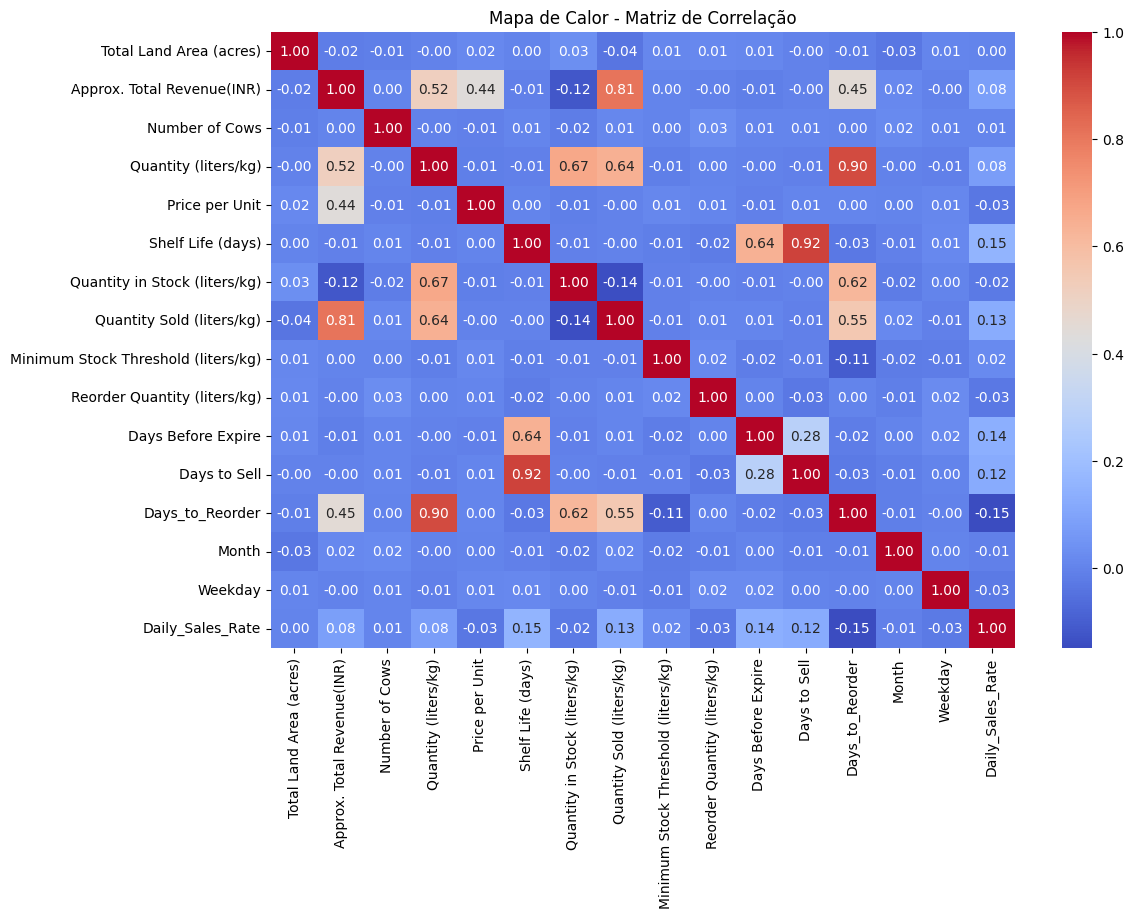

In [30]:
# Criar um mapa de calor para a matriz de correlação
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Mapa de Calor - Matriz de Correlação")
plt.show()